# Detecting Visuo-Haptic Mismatches in Virtual Reality using the Prediction Error Negativity of Event-Related Brain Potentials

Students: 
1. Yonatan Mamo (st188726)
2. Milana Shkhanukova (st191432)


## 1. Introduction

This project replicates and extends the analysis of Prediction Error Negativity (PEN) in **visuo-haptic mismatch** scenarios in VR. We used data from the “Detecting Visuo-Haptic Mismatches in Virtual Reality” study (OpenNeuro ds003846 v2.0.2). Participants experienced different VR conditions:
- **EMS:** Electrical muscle stimulation
- **Visual:** Purely visual feedback
- **Vibro:** Vibrotactile feedback

Each trial was either *normal* (aligned visual/haptic cues) or *conflict* (mismatch). The goal was to identify whether conflict trials elicited a stronger negative ERP at channel FCz (the PEN) compared to normal trials.

---

In [ ]:
from pathlib import Path
import mne
import sys
import os

src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.append(src_path)

from src.data_loader import load_raw_sessions
from src.preprocessing import preprocess_raw_sessions
from src.ica import run_ica_label_exclude
from src.sanity_checks import check_channel_statistics, plot_psd_sanity

Note:  we need the EEG data to work with. Use the `ds003846-2.0.2.sh` script in this repo to download the data. The data is organized into folders by subject, and each folder has sessions for different conditions.

## 2. Pipeline Overview
We processed the EEG with the following steps (implemented in `src/`):
- Load the EEG files
- Preprocess:
  - Bandpass 1–125 Hz
  - Downsample to 250 Hz
  - Average re-reference
  - Notch filter at 50 Hz
- Remove artifacts via ICA + ICLabel
- Compare ERPs across conditions (group-level, FCz focus)

We illustrate these steps first on a single subject (`sub-02`), then apply them to all subjects for group-level analysis.


## 3. Data Loading

The channel names in the dataset have a prefix ("BrainVision RDA_") that is specific to the recording system We need to remove this prefix to match the standard EEG channel naming convention (e.g., "Fp1", "Fz")

In this step we add a reference channel which is a FCz for us as it it provides a balanced reference point for neural activity across the scalp. In addition, we set teh standard Standard 10-20 Electrode Placement to make sure the electrode positions are correctly assigned according to a standardized layout and we can futher visualizing EEG topographies, as it can be seen on the graph below.

In [ ]:
subject = "sub-02"
base_path = Path("./ds003846-2.0.2")
raw_sessions = load_raw_sessions(base_path, subject)
data_paths = {
    "ses-EMS": base_path / subject / "ses-EMS" / "eeg",
    "ses-Visual": base_path / subject / "ses-Visual" / "eeg",
    "ses-Vibro": base_path / subject / "ses-Vibro" / "eeg"
}

Loading data for ses-EMS from ds003846-2.0.2/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Extracting parameters from ds003846-2.0.2/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 258029  =      0.000 ...   516.064 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Loading data for ses-Visual from ds003846-2.0.2/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Extracting parameters from ds003846-2.0.2/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 959079  =      0.000 ...  1918.184 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Loading data for ses-Vibro from ds003846-2.0.2/sub-02/ses-Vibro/eeg/sub-02_ses-Vibro_task-PredictionError_eeg.vhdr...
Extracting parameters from ds003846-2.0.2/sub-02/ses-Vibro/eeg/sub-02_ses-Vib

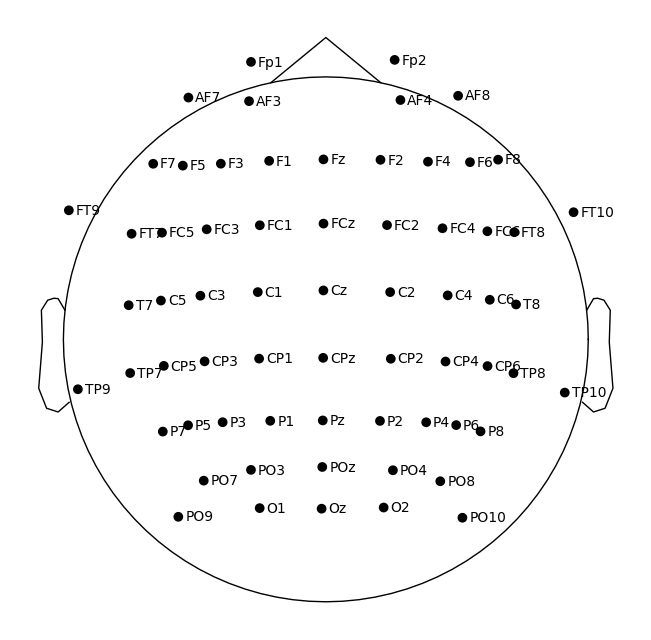

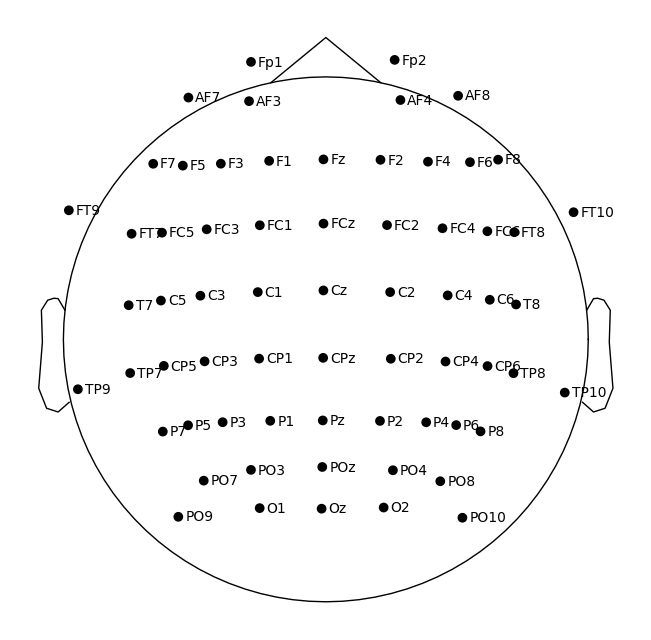

In [ ]:
raw_sessions["ses-EMS"].plot_sensors(kind="topomap", show_names=True)

## 4. Preprocessing and Sanity Checks
### 4.1 Filter, Downsample, Re-reference

On the next step we're focusing on the filtering of the data. 

ERP components are small signals, so cleaning the data is crucial for detection. Moreover, accurate preprocessing ensures that only neural activity is analyzed (not artifacts).


This step includes the following operations:
1. Bandpass filtering: Removes DC drifts and high-frequency noise.
2. Downsampling: Reduces data size but retains ERP-relevant frequencies.
3. Re-referencing: Balances overall scalp activity, with FCz included in the montage.
4. Notch filtering: Attenuates line noise.

Note: the parameters for the filtering are saved in ./src/config.py


In [ ]:
raw_sessions = preprocess_raw_sessions(raw_sessions)


--- Preprocessing ses-EMS ---
  Filtering 1.0–124.9 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


  Downsampling to 250 Hz...
  Re-referencing to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
  Applying notch filter at [50] Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

  ses-EMS info: 65 channels, sampling rate: 250.0 Hz

--- Preprocessing ses-Visual ---
  Filtering 1.0–124.9 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


  Downsampling to 250 Hz...
  Re-referencing to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
  Applying notch filter at [50] Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


  ses-Visual info: 65 channels, sampling rate: 250.0 Hz

--- Preprocessing ses-Vibro ---
  Filtering 1.0–124.9 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


  Downsampling to 250 Hz...
  Re-referencing to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
  Applying notch filter at [50] Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


  ses-Vibro info: 65 channels, sampling rate: 250.0 Hz


### 4.2 Sanity Checks

In [ ]:
for session, raw in raw_sessions.items():
    check_channel_statistics(raw, session)


Channel statistics for ses-EMS:
  Fp1: mean = -0.0000000656, std = 0.0000251872
  Fp2: mean = -0.0000000705, std = 0.0000279831
  F7: mean = -0.0000000170, std = 0.0000210656
  F3: mean = -0.0000000618, std = 0.0000106873
  Fz: mean = -0.0000000386, std = 0.0000049625
  F4: mean = -0.0000000576, std = 0.0000093866
  F8: mean = -0.0000000025, std = 0.0000188245
  FC5: mean = 0.0000000029, std = 0.0000122467
  FC1: mean = -0.0000000330, std = 0.0000052137
  FC2: mean = -0.0000000232, std = 0.0000053625
  FC6: mean = -0.0000000015, std = 0.0000125779
  T7: mean = 0.0000000176, std = 0.0000135748
  C3: mean = 0.0000000028, std = 0.0000054340
  Cz: mean = -0.0000000319, std = 0.0000048458
  C4: mean = 0.0000000070, std = 0.0000054445
  T8: mean = 0.0000000771, std = 0.0000130817
  TP9: mean = 0.0000000360, std = 0.0000113081
  CP5: mean = 0.0000000106, std = 0.0000069453
  CP1: mean = 0.0000000126, std = 0.0000052721
  CP2: mean = 0.0000000145, std = 0.0000053004
  CP6: mean = 0.0000000184

Plotting PSD for sanity check of ses-EMS...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Plotting PSD for sanity check of ses-Visual...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).
Plotting PSD for sanity check of ses-Vibro...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


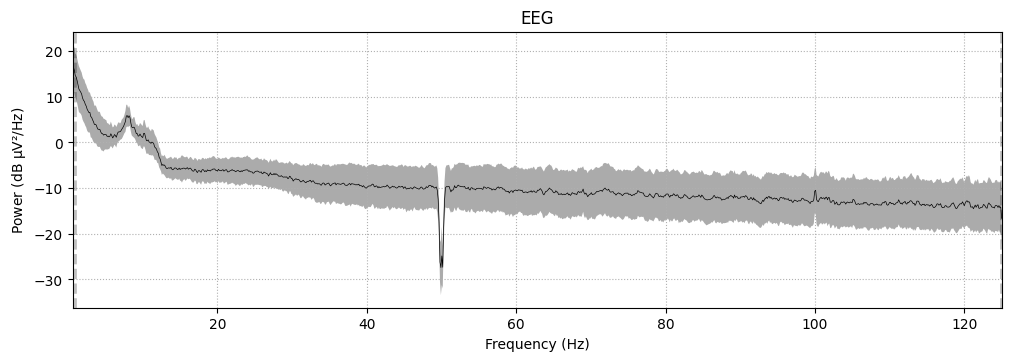

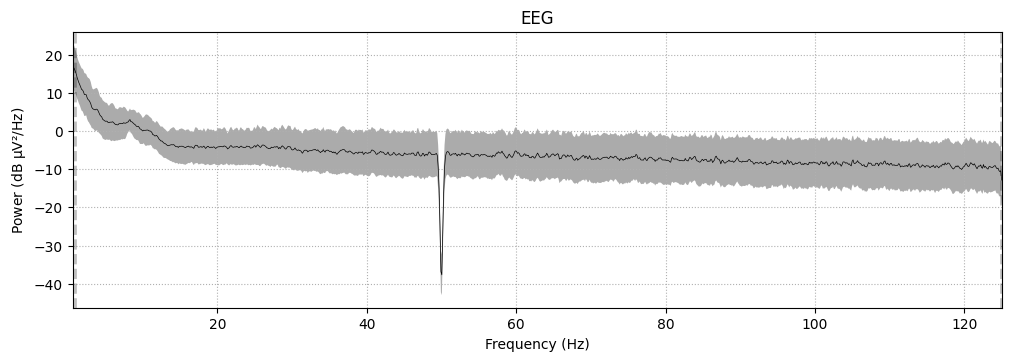

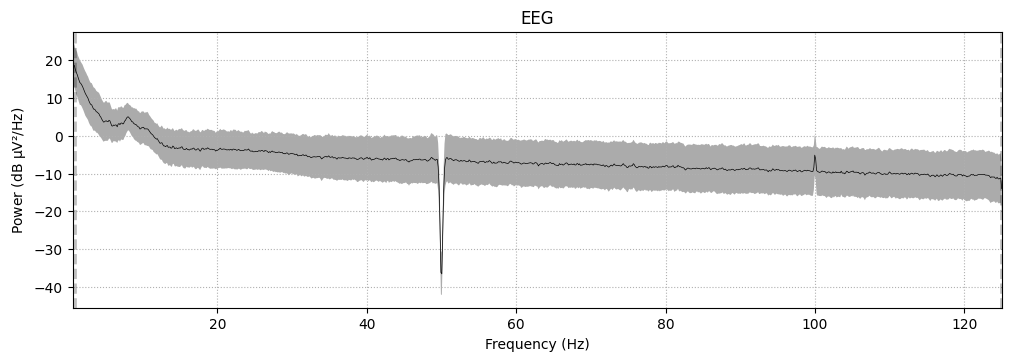

In [ ]:
for session, raw in raw_sessions.items():
    plot_psd_sanity(raw, session)

From the plots above we can conclude:
1. A flat PSD curve would indicate a dead or disconnected electrode. Since no such extreme flat line appears, there are no completely dead channels, but individual channel inspection is still needed.
2. High Power at low frequencies (1–10 Hz), is significantly high in the lower frequency range, which could indicate eye movement artifacts (especially below 3 Hz). 
3. From the channel statistics, no channel appeared fully dead; all had mean and standard deviations within a small range (~10–30 µV) which is expected after refrencing to average. 
4. Looking at the PSD, we see a dip at 50 Hz, indicating that the notch filter effectively removed the line noise.

## 5. ICA Analysis

ICA analysis is a necessary step to separate the eye blink activity, line noise and other artifacts.  

The paper also does this but after their intial 1 second window epoching and noisy epochs removal. We think this might be because it helps the ICA result when the data is clean. But in our pipeline we directly do the ICA analysis.

In [ ]:
ica_fitted, ica_sessions = run_ica_label_exclude(raw_sessions)


=== ICA for ses-EMS ===
  Fitting ICA...
Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Extended Infomax ICA
Fitting ICA took 14.9s.
  Labeling ICA components with ICLabel...


/Users/yonatan/prederror/prediction_error_EEG/src/ica.py:41: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ICLabel assigned: ['eye blink', 'eye blink', 'brain', 'eye blink', 'brain', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'other', 'muscle artifact', 'muscle artifact']
  Excluding components: [0, 1, 3, 6, 8, 10, 12, 14, 15, 16, 18, 19]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 65 PCA components

=== ICA for ses-Visual ===
  Fitting ICA...
Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Extended Infomax ICA


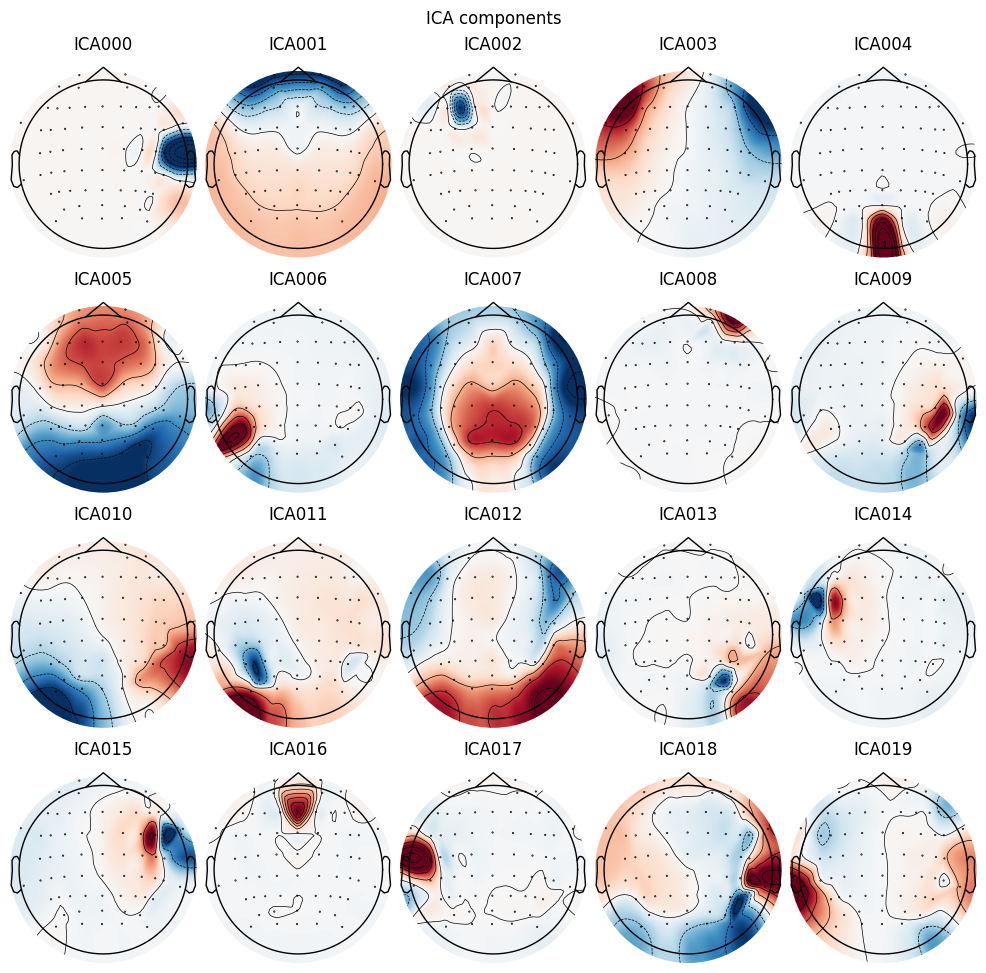

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated


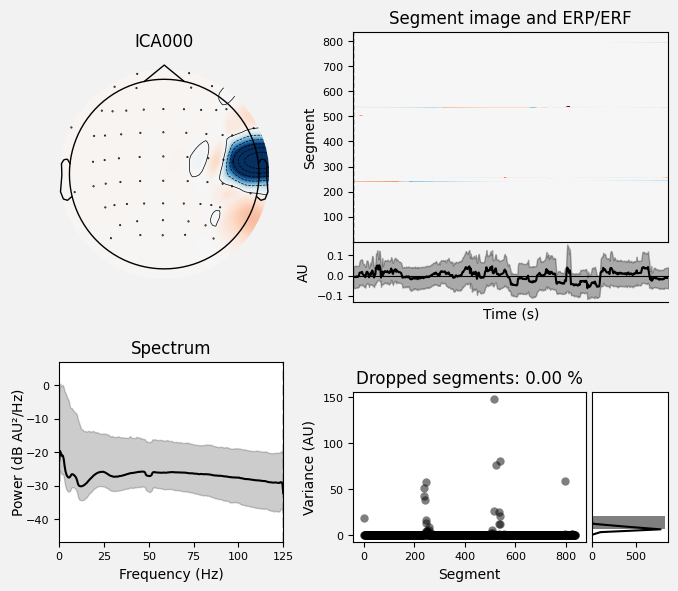

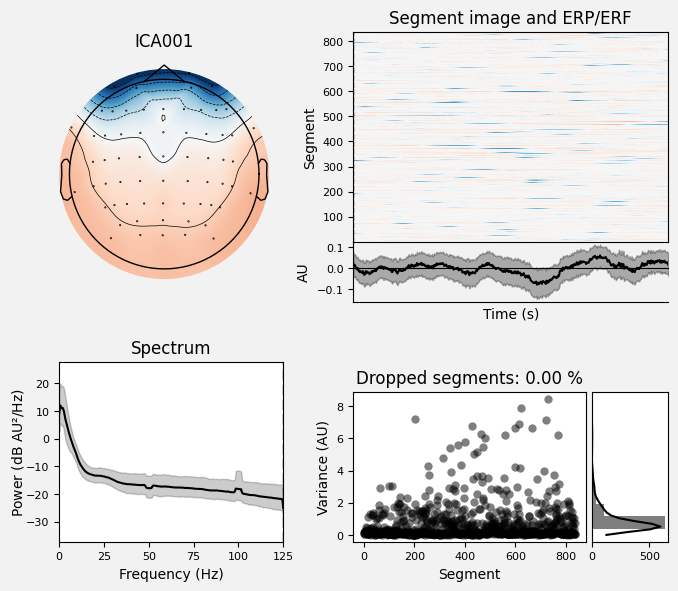

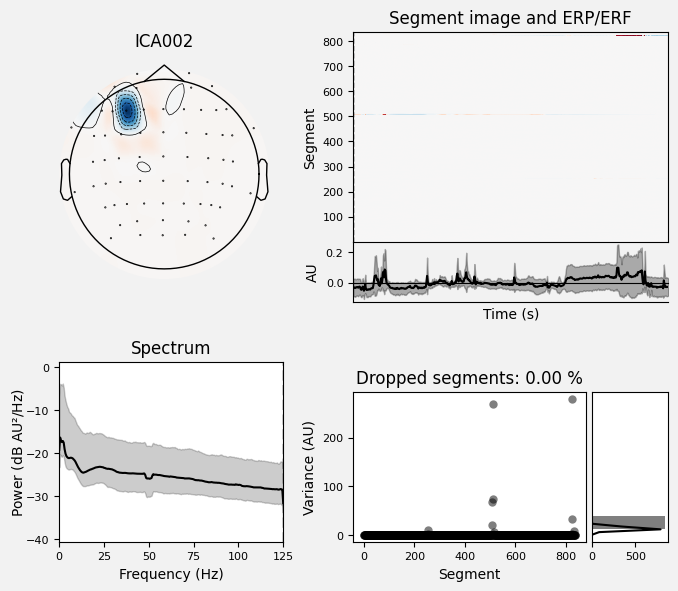

Creating RawArray with float64 data, n_channels=20, n_times=419386
    Range : 0 ... 419385 =      0.000 ...  1677.540 secs
Ready.
Using matplotlib as 2D backend.


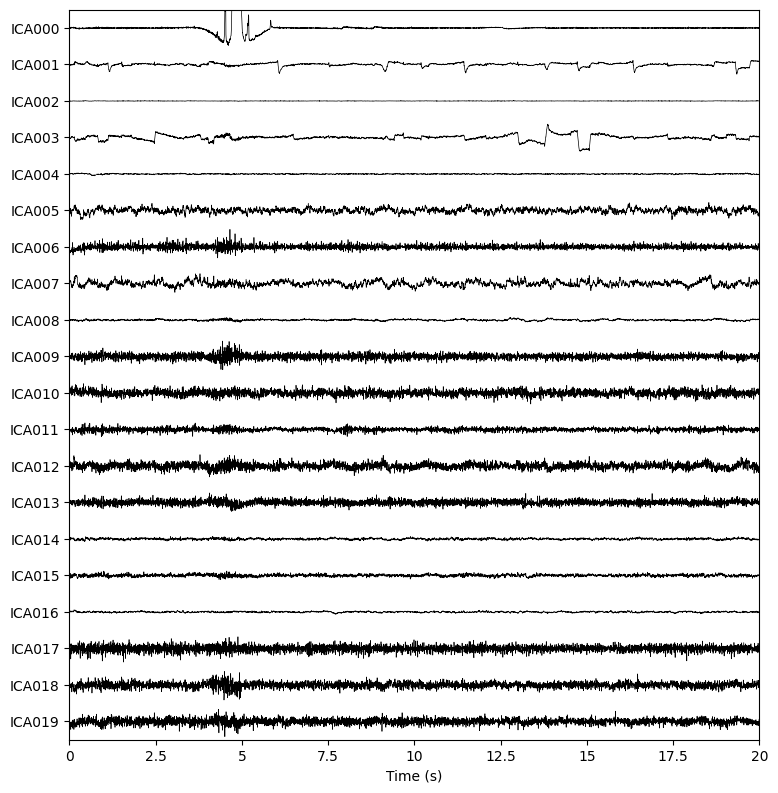

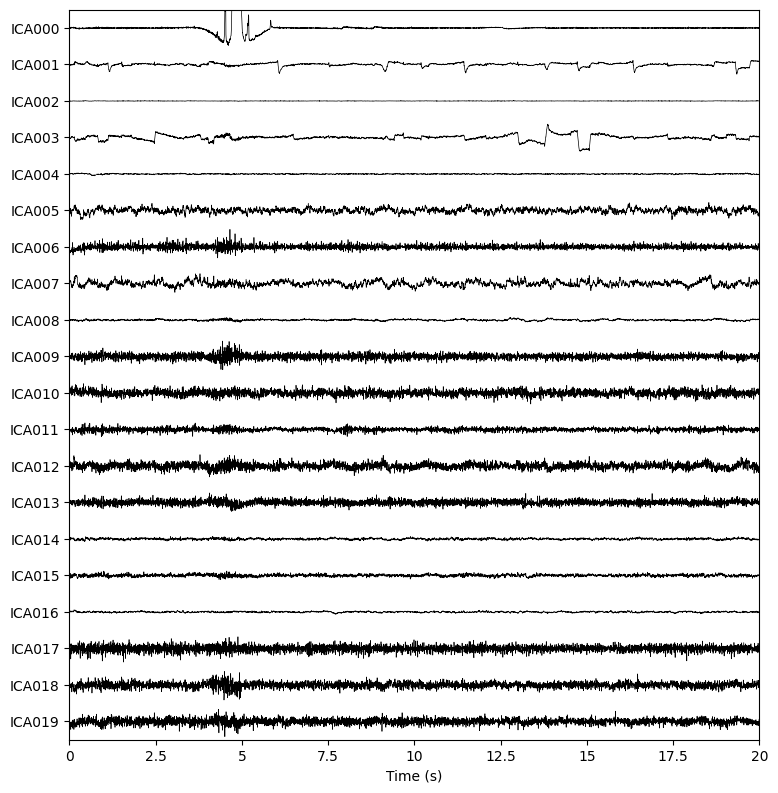

In [ ]:
ica_fitted.plot_components()
# Inspect components 0, 1, 2 in detail
ica_fitted.plot_properties(raw, picks=[0, 1, 2])
ica_fitted.plot_sources(raw, show_scrollbars=False, show=True)

As we can see ICA assigned quite a lot of labels for brain, hear beat, eye blink and channel noise components. 

Now we will visualize the raw and processed ica sessions. As we can observe, the signals for all of the sessions became less noisy and 

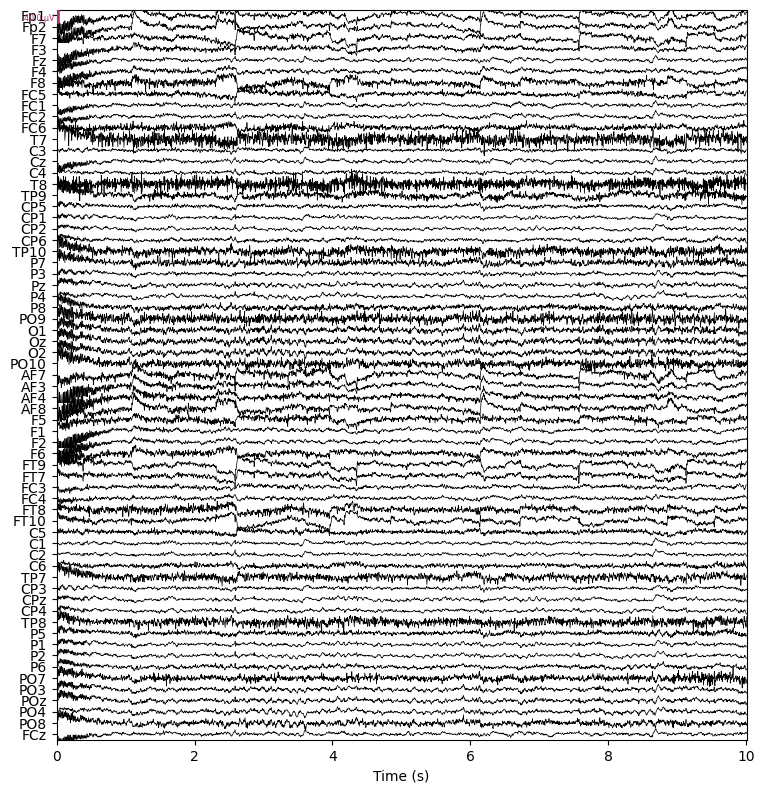

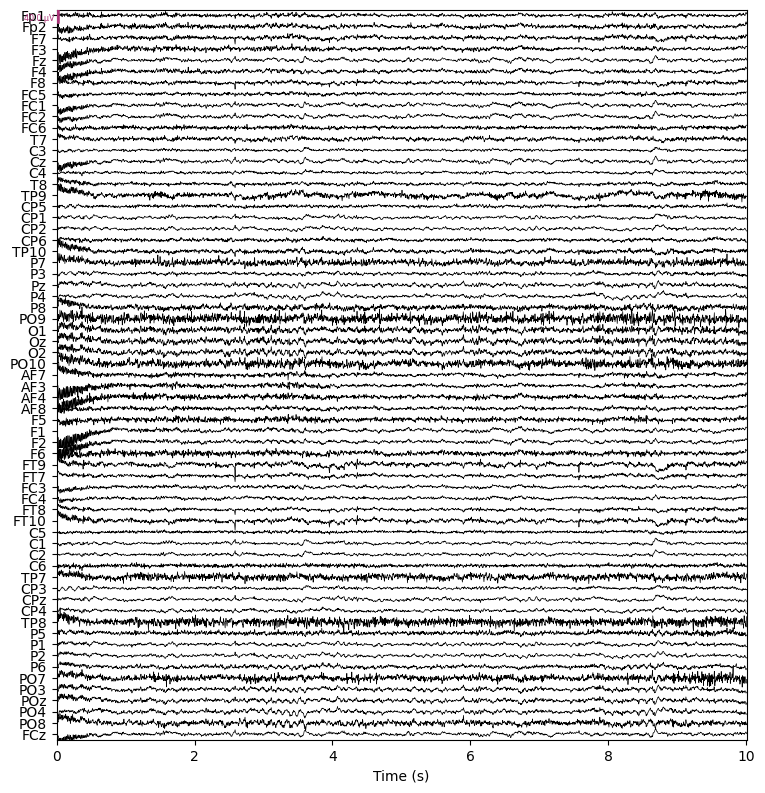

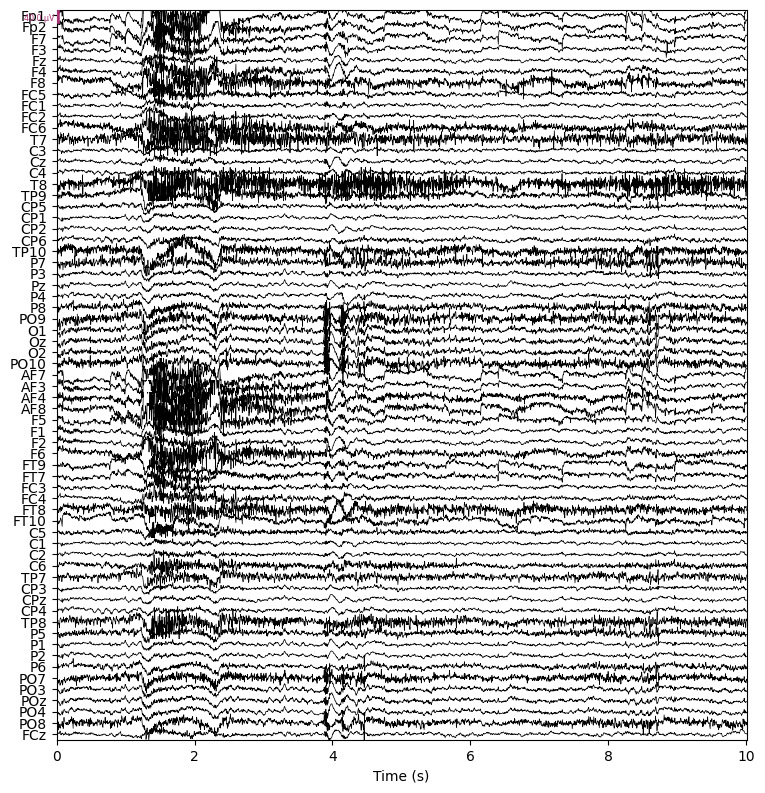

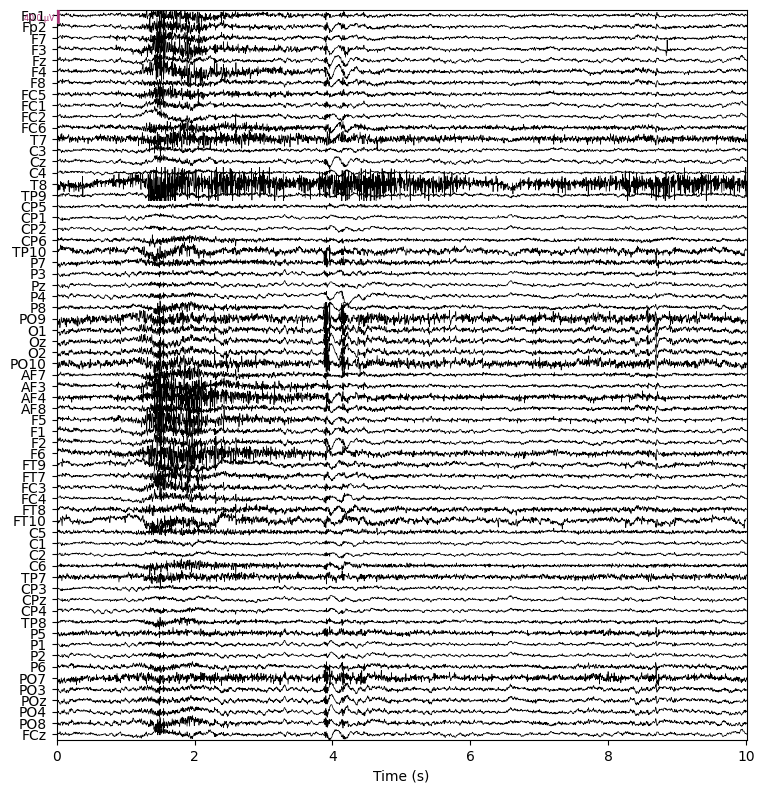

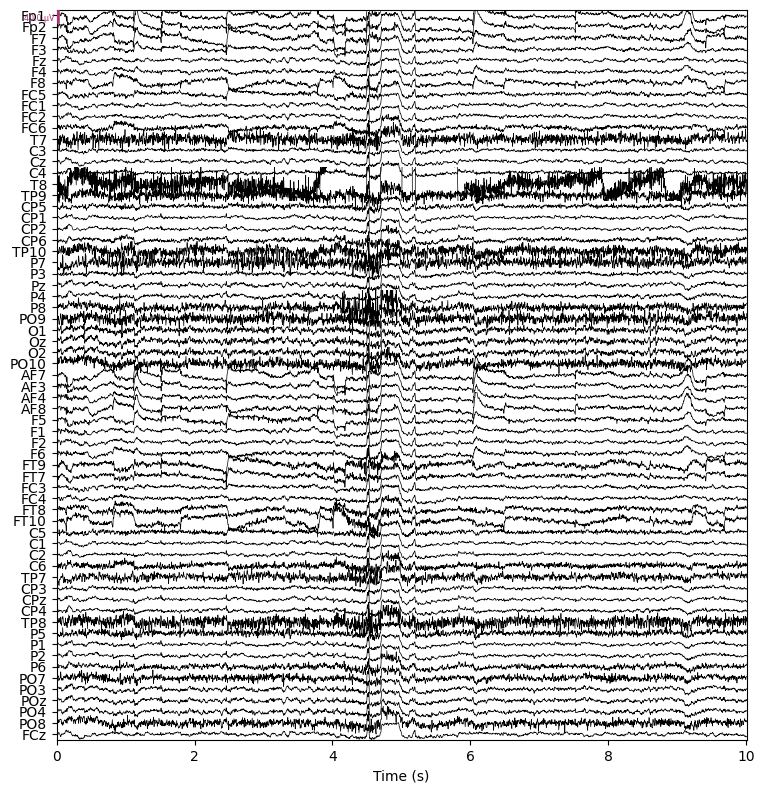

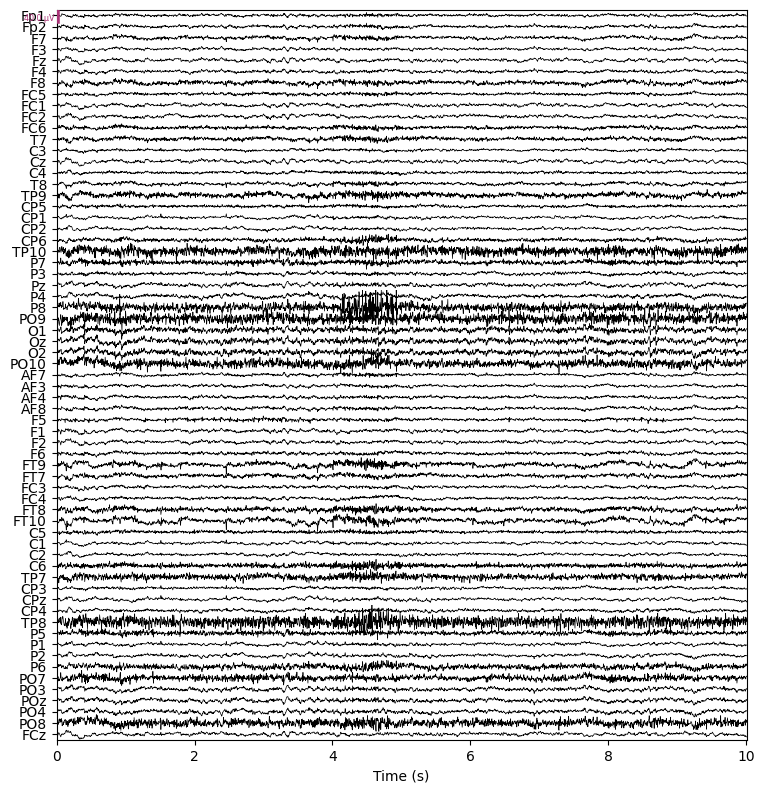

In [ ]:
for raw, processed_raw in zip(raw_sessions.values(), ica_sessions.values()):

    artifact_picks = mne.pick_channels(raw.info['ch_names'], include=[])

    # Visualize the FCz channel before & after
    raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)
    processed_raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

# Key Preprocessing Results

1. **Better signal quality**: Our filtering techniques significantly improved signal clarity, making it easier to detect brain responses to sensory mismatches
2. **Reduced noise**: We successfully preserved important brain signals while removing unwanted artifacts

# Visualizations per subject

The main idea of the project can be validated using mean responses of the subjects per different sessions. In this section we're trying to reimplement their visualization. 

After processing only one sample, we extended the pipeline and processed all of the files for all present subjects and saved the raw data of ica to files .fif dataset format to further reuse. 

### Steps:
4. Epoching per stimulus for all of the subjects.
5. ERP analysis and visualizations.


# Step 4. Epoching 
We create epochs aligned to the stimulus event `box:touched` which is the moment of object selection. In the paper they state "Then we sliced it between -0.3 seconds to 0.7 seconds around the stimulus onset, i.e. the moment of object selection". We think the `box:touched` probably correponds to the "moment of object selection" so thats what we are using to align out epochs. 

In this function, we isolate EEG segments (epochs) related to "normal" and "conflict" conditions, making it possible to analyze brain activity differences between them. In addition, the function detects and removes the noisiest 20% of trials, improving data quality for statistical analysis.



In [10]:
from src.epoching import process_subject_epochs, compute_grand_averages, plot_evoked_comparisons

In [11]:

# after some trials we found the "outlier" subjects to remove
subjects = [
        'sub-13',
        # 'sub-14',
        # 'sub-15',
        # 'sub-12',
        'sub-08',
        'sub-06',
        'sub-07',
        # 'sub-11',
        'sub-16',
        'sub-02']

sessions = ["ses-EMS", "ses-Vibro", "ses-Visual"]

# path of the original data where events are saved.
base_path = Path("./ds003846-2.0.2")
# path of the processed ica data
processed_base_path = Path("./processed_eeg_data")
# event ID mapping: integer codes for each condition
event_id = {"normal": 2, "conflict": 3}

In [12]:
group_evokeds = process_subject_epochs(
    subjects, sessions, base_path, processed_base_path, event_id
)

Processing sub-13, ses-EMS...
Opening raw data file processed_eeg_data/sub-13/ses-EMS_cleaned_raw.fif...
    Range : 0 ... 183917 =      0.000 ...   735.668 secs
Ready.
Reading 0 ... 183917  =      0.000 ...   735.668 secs...
Not setting metadata
206 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 206 events and 251 original time points ...
0 bad epochs dropped
Dropped 41 epochs: 36, 37, 38, 39, 46, 47, 84, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 102, 103, 108, 109, 120, 121, 138, 139, 146, 147, 148, 149, 150, 151, 174, 175, 188, 189, 200, 201, 202, 203
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Processing sub-13, ses-Vibro...
Opening raw data file processed_eeg_data/sub-13/ses-Vibro_cleaned_raw.fif...
    Range : 0 ... 509638 =      0.000 ...

# Epoch 5. ERP Analysis 

At this step, we're computing the average event-related potentials (ERPs) for normal and conflict conditions, apply a 10 Hz low-pass filter, and calculate the difference waveform (conflict - normal) over all the subjects we've processed.

In [13]:
grand_averages = compute_grand_averages(group_evokeds, sessions)

Not setting metadata
749 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
242 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1248 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
415 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
1076 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
364 matching events found
Applying baseline correction (mode: mean)


/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:100: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_normal = all_normal_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:101: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_conflict = all_conflict_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:100: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_normal = all_normal_epochs.average().filter(l_freq=None, h_freq=10, verbose=False)
/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:101: RuntimeWarning: filter_length (331)

Then we plot the grand-averaged ERPs across sessions for normal, conflict, and difference conditions, using distinct colors and styles for each session. Our major goal was to compare whether we reach the same findings as the authors of the paper. As we can observe on the graphs below, our processing pipeline and the final graphs over the events matches with the original authors findings. 

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:130: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  viz.plot_compare_evokeds(
/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:130: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  viz.plot_compare_evokeds(
/Users/yonatan/prederror/prediction_error_EEG/src/epoching.py:130: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  viz.plot_compare_evokeds(


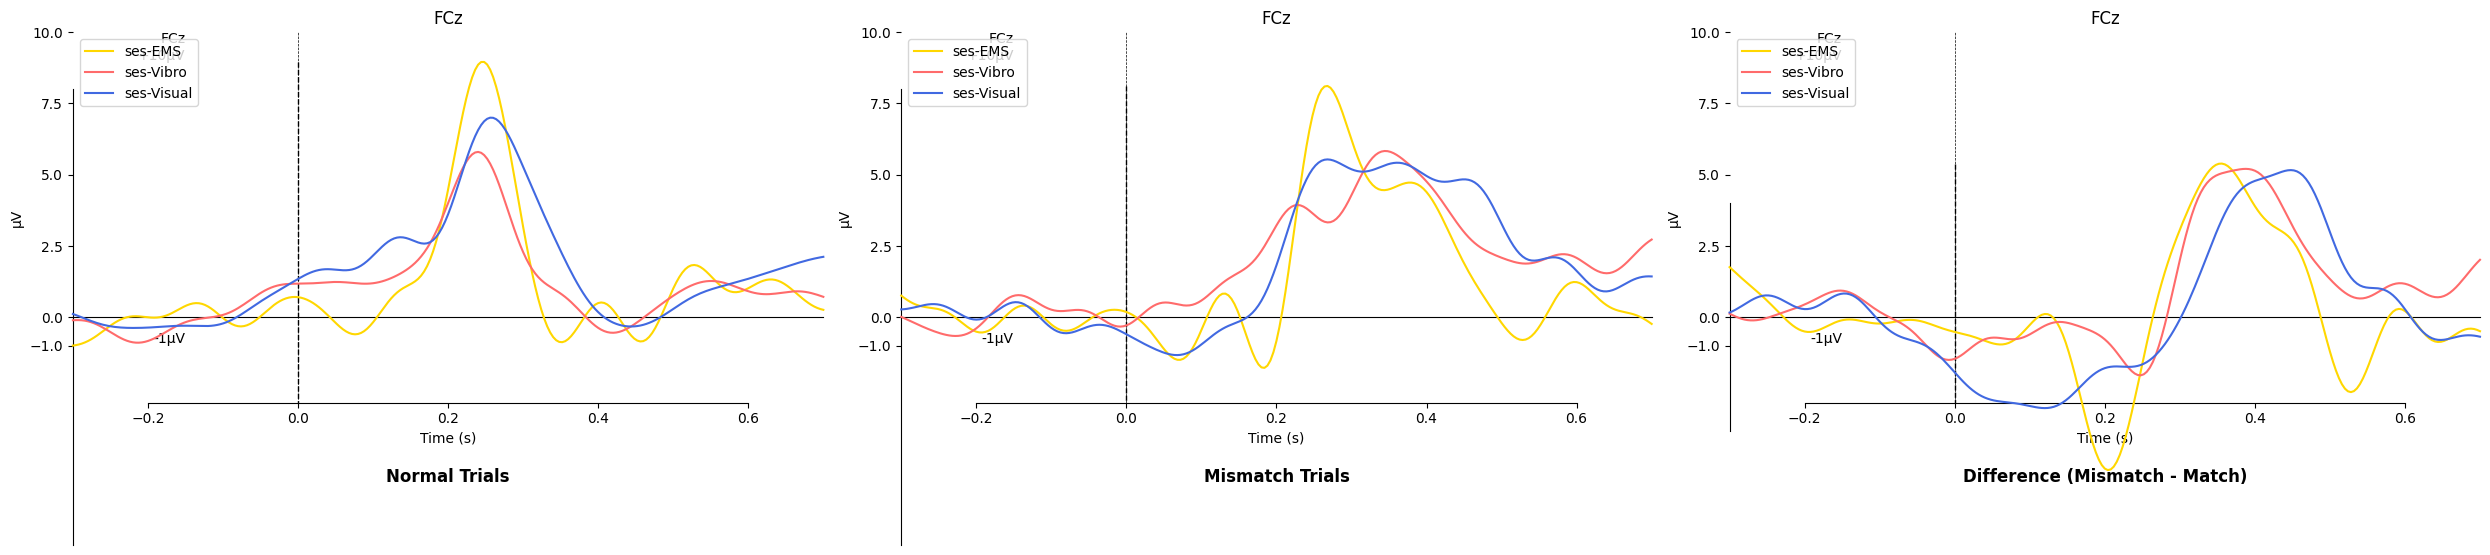

In [14]:
plot_evoked_comparisons(grand_averages, sessions)

![Alt text](./figures/graph_paper.png)

# Results

Our results support the paper's conclusion that brain potentials can be used to detect visuo-haptic conflicts in VR. The difference waveform reveals a negative deflection around 0.2-0.3 seconds after stimulus, which appears to be the Prediction Error Negativity and matches with the results in the paper. The prediction error negativity appears most pronounced in the EMS condition, suggesting this feedback type may produce the most detectable neural signals when mismatches occur. Moreover, Figure 5 in the paper and our graph for the match and mismatch differences confirm this with clear visualization of the "strong prediction error negativity" around -4μV.


The paper notes no significant differences in subjective immersion between conditions (as mentioned in the "Questionnaire and users' comments" section), highlighting the value of these objective neural measures for detecting conflicts that users might not consciously report.